In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from datetime import datetime
from sklearn.svm import SVC
import operator
import googlefinance.client as gfc
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize


import quandl

%matplotlib notebook

The goal of this notebook is to create time series regression models using some regression models as well as "Forest" models (both regression and deep learning versions). 

The features for this part of the research are going to be extracted using data freely available in Python via Quandl and pandas Yahoo finance support. 

- NASDAQ Composite
- Dow Jones Industrial Average
- Frankfurt DAX
- London FTSE-100
- Paris CAC 40
- Tokyo Nikkei-225
- Hong Kong Hang Seng
- Australia ASX-200

The features will be extracted from the major market indicators above will have the following format:

- Date : in days

- Open : price of the stock at the opening of the trading (in US dollars)
- High : highest price of the stock during the day (in US dollars)
- Low : lowest price of the stock during the trading day (in US dollars)
- Close : price of the stock at the closing of the trading (in US dollars)
- Volume : amount of stocks traded (in US dollars)
- Adj Close : price of the stock at the closing of the trading adjusted with dividends (in US dollars)

In [52]:
# Get googlefinance major global ETF data

period = "12M"

params = [
    {'q': "IXIC",
     'x': 'INDEXNASDAQ'
    },
    {'q': '.DJI',
      'x': 'INDEXDJX'  
    },
    {'q':'DAX',
     'x':'INDEXDB'   
    },
    {'q': 'UKX',
      'x':'INDEXFTSE'   
    },
    {'q': 'PX1',
      'x': 'INDEXEURO'   
    },
    {'q': 'NI225',
      'x': 'INDEXNIKKEI'  
    },
    {'q': 'HSI',
      'x': 'INDEXHANGSENG'  
    },
    {'q': 'XJO',
      'x':'INDEXASX'   
    },
    {'q': "SPY",
     'x': 'NYSEARCA'
    }
]

feats1 = gfc.get_closing_data(params, period)


quandl.ApiConfig.api_key = "a1LZ4iFxZS6mzZUsf28u"
feats2 = quandl.get("USTREASURY/YIELD",start_date='2016-09-09',
                   end_date='2017-09-09')

x = feats1
y = feats2

# Ugly but useful. recursively merge the two data frames
for i in y.columns:
    x[i] = y[i]
x = x.dropna()
y = x.pop('SPY')
X = x

In [53]:
X.shape, y.shape

((216, 19), (216,))

In [54]:
# Predict shift_by dates away: e.g. shift_by=10 -> two weeks out
shift_by = 10


#Clean and shift the data
X = X.dropna()
y = y.shift(shift_by).dropna() 
X = X[:-shift_by]


# Normalize the features using sklearn normalize
X = normalize(X)


In [55]:
X.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
y.head()

In [ ]:
X.shape, y.shape

In [ ]:
# Use 95% to train of the 12 month data set

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
training_range = int(X.shape[0] * .90)
X_train = X[0:training_range]
y_train = y[0:training_range]

X_test = X[training_range: ]
y_test = y[training_range: ]

In [ ]:
y_train.head()

# Ordinary Least Square

<IPython.core.display.Javascript object>


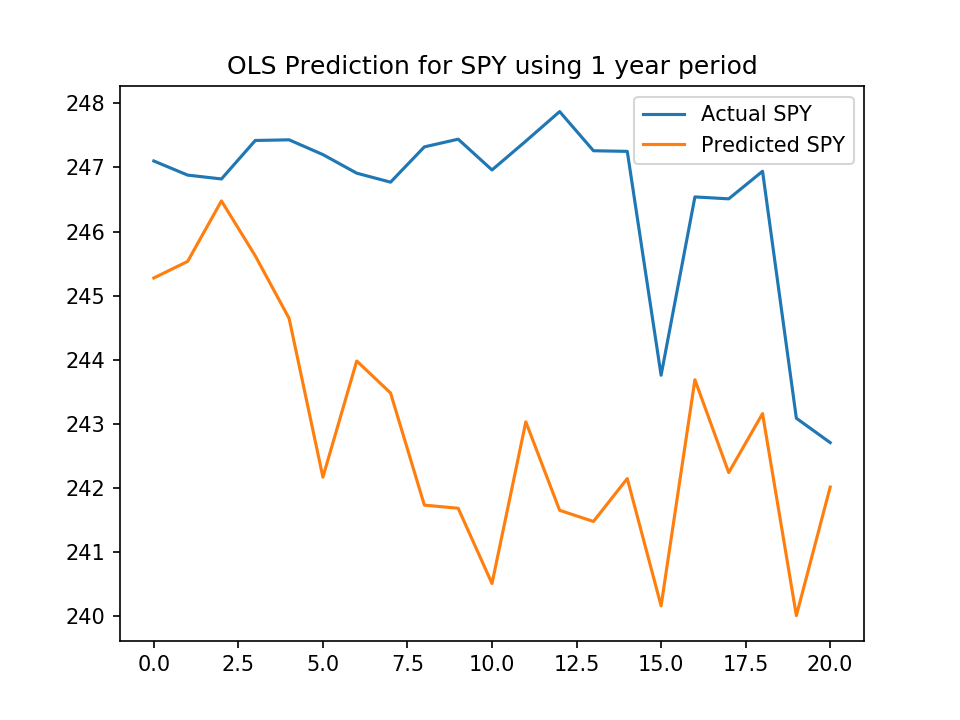

-7.2126961611474378

In [56]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_predicted = reg.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(y_predicted, label='Predicted SPY')
ax.set_title('OLS Prediction for SPY using 1 year period')
plt.legend()



reg.score(X_test, y_test)

In [57]:
sY = y
sX = X
sX = sm.add_constant(sX)

model = sm.OLS(sY,sX)
results = model.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                  OLS                Adj. R-squared:       0.981    
Dependent Variable:     SPY                AIC:                  787.6314 
Date:                   2017-09-09 13:02   BIC:                  854.1890 
No. Observations:       206                Log-Likelihood:       -373.82  
Df Model:               19                 F-statistic:          545.3    
Df Residuals:           186                Prob (F-statistic):   4.89e-152
R-squared:              0.982              Scale:                2.4437   
--------------------------------------------------------------------------
          Coef.       Std.Err.     t    P>|t|      [0.025        0.975]   
--------------------------------------------------------------------------
const      826.9742    595.2195  1.3894 0.1664     -347.2749     2001.2233
x1         717.4613    142.1231  5.0482 0.0000      437.0808      997.8418
x2        -123.6145    312.0185 -0.3962 0.6924     -739.1646      491.9356
x3         -83.4560    153.1300 -0.5450 0.5864     -385.5509      218.6388
x4        -503.3556    142.3546 -3.5359 0.0005     -784.1927     -222.5185
x5         -45.9063    183.4723 -0.2502 0.8027     -407.8604      316.0477
x6        -384.5257    280.0982 -1.3728 0.1715     -937.1034      168.0520
x7        -412.0722    352.9519 -1.1675 0.2445    -1108.3757      284.2314
x8        -569.9567     98.3741 -5.7938 0.0000     -764.0290     -375.8843
x9      347101.8039 117595.8075  2.9517 0.0036   115108.7815   579094.8262
x10     202622.5896 200556.3869  1.0103 0.3137  -193035.0734   598280.2526
x11    -544062.3504 258577.1320 -2.1041 0.0367 -1054183.3458   -33941.3550
x12    -667207.7377 259265.2475 -2.5735 0.0108 -1178686.2476  -155729.2279
x13    1020489.4066 447752.5973  2.2791 0.0238   137163.0316  1903815.7815
x14    1065509.5175 565761.7444  1.8833 0.0612   -50625.3164  2181644.3513
x15     350638.4411 604951.0601  0.5796 0.5629  -842809.0793  1544085.9615
x16   -1112375.5210 648843.9781 -1.7144 0.0881 -2392414.9949   167663.9529
x17   -1491840.8803 590361.4497 -2.5270 0.0123 -2656506.0155  -327175.7451
x18    4224465.2745 447509.7524  9.4399 0.0000  3341617.9839  5107312.5652
x19   -2892783.7949 351612.5858 -8.2272 0.0000 -3586445.1442 -2199122.4455
--------------------------------------------------------------------------
Omnibus:                1.364          Durbin-Watson:             0.990   
Prob(Omnibus):          0.506          Jarque-Bera (JB):          1.196   
Skew:                   0.186          Prob(JB):                  0.550   
Kurtosis:               3.035          Condition No.:             11100866
==========================================================================
* The condition number is large (1e+07). This might indicate
strong multicollinearity or other numerical problems.
"""

# Ridge Method

<IPython.core.display.Javascript object>


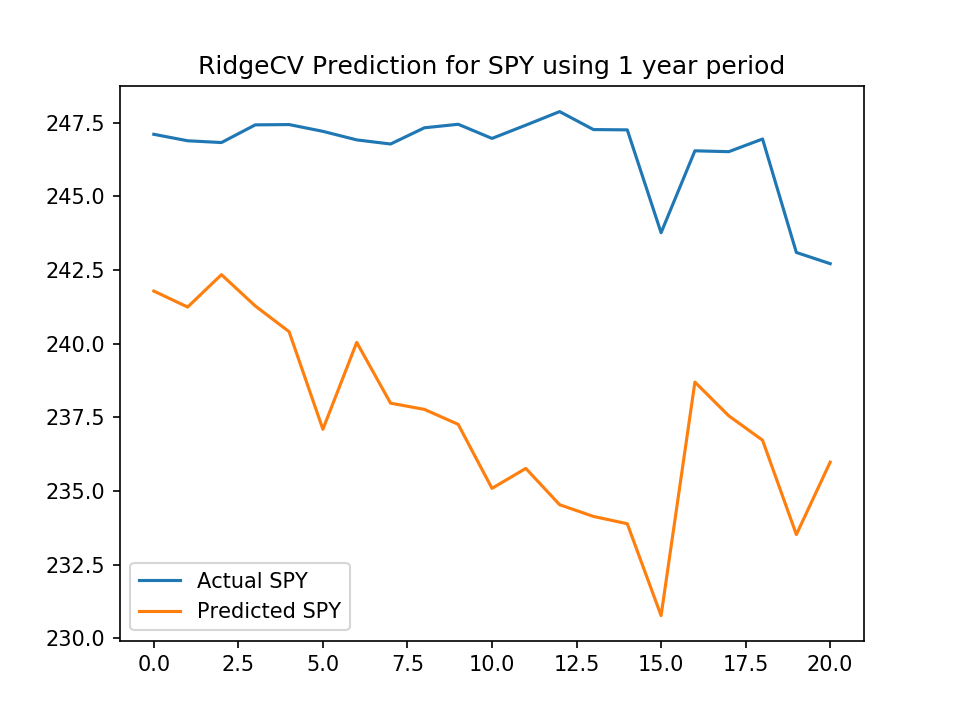

-45.016686842189692

In [58]:
ridge = linear_model.Ridge(alpha=1e-6)
ridge.fit(X_train, y_train)
y_ridge_predicted = ridge.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(y_ridge_predicted, label='Predicted SPY')
ax.set_title('RidgeCV Prediction for SPY using 1 year period')
plt.legend()

ridge.score(X_test, y_test)

# Lasso 

<IPython.core.display.Javascript object>


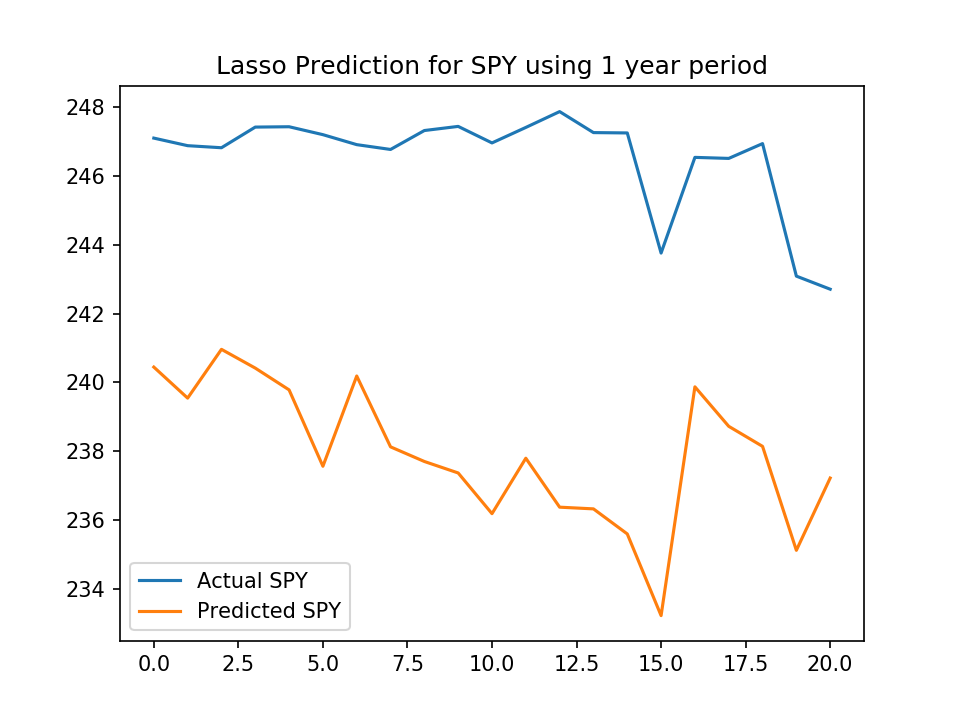

-37.507926802946727

In [64]:
lasso = linear_model.Lasso(alpha = 1e-3)
lasso.fit(X_train, y_train)

y_predicted = lasso.predict(X_test)

fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(y_predicted, label='Predicted SPY')
ax.set_title('Lasso Prediction for SPY using 1 year period')
plt.legend()

lasso.score(X_test, y_test)

# Random Forest Regressor

<IPython.core.display.Javascript object>


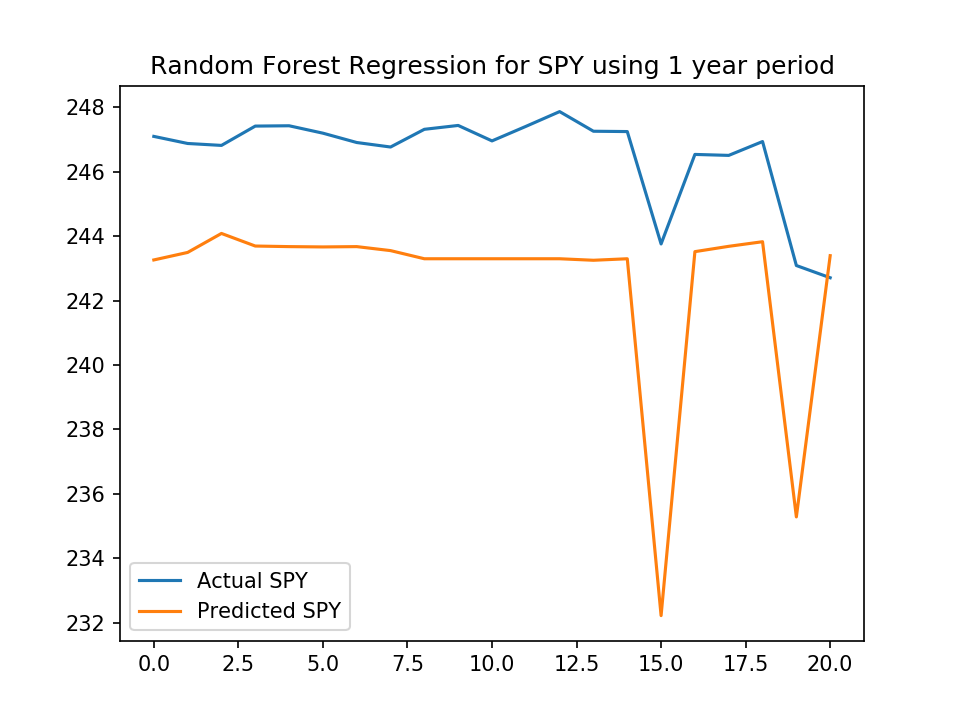

-9.2228365897908109

In [65]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)
regr_predicted = regr.predict(X_test)
fig, ax = plt.subplots()
ax.plot(y_test.values, label='Actual SPY')
ax.plot(regr_predicted, label='Predicted SPY')
ax.set_title('Random Forest Regression for SPY using 1 year period')
plt.legend()

regr.score(X_test, y_test)


In [73]:
feats3 = quandl.get('USTREASURY/HQMYC', start_date='2016-09-09',
                   end_date='2017-09-09')

In [74]:
feats3.head()

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,95.5,96.0,96.5,97.0,97.5,98.0,98.5,99.0,99.5,100.0
Month,,,,,,,,,,,,,,,,,,,,,
2016-09-30,0.90,1.09,1.26,1.39,1.49,1.56,1.63,1.70,1.78,1.88,...,4.51,4.51,4.51,4.51,4.51,4.51,4.51,4.51,4.51,4.51
2016-10-31,0.94,1.16,1.35,1.49,1.60,1.67,1.74,1.81,1.90,1.99,...,4.60,4.60,4.60,4.61,4.61,4.61,4.61,4.61,4.61,4.61
2016-11-30,0.97,1.24,1.48,1.67,1.82,1.94,2.04,2.14,2.25,2.36,...,4.91,4.91,4.91,4.91,4.92,4.92,4.92,4.92,4.92,4.92
2016-12-31,1.12,1.41,1.67,1.88,2.06,2.21,2.34,2.46,2.58,2.71,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
2017-01-31,1.16,1.41,1.63,1.83,2.00,2.14,2.28,2.40,2.53,2.65,...,4.83,4.83,4.83,4.83,4.83,4.83,4.83,4.83,4.83,4.83
